# Librairies

In [67]:
import os, warnings, joblib
import pandas as pd
import numpy as np
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, StratifiedKFold

# data preparation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# model
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

# fine tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

# Import data

![](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [2]:
STORAGE_PATH = '../data'
INPUT_FOLDER = 'inputs'
OUTPUT_FOLDER = 'outputs'

In [3]:
print(f'''
* number of datasets: {len(os.listdir(os.path.join(STORAGE_PATH, INPUT_FOLDER)))}
''')


* number of datasets: 11



In [4]:
train_set = pd.read_csv(os.path.join(STORAGE_PATH, INPUT_FOLDER, 'application_train.csv'))
test_set = pd.read_csv(os.path.join(STORAGE_PATH, INPUT_FOLDER, 'application_test.csv'))

# EDA

In [5]:
print(f'''
* train set shape:\t{train_set.shape}\t({len(train_set) / len(train_set):.0%})
* test set shape:\t{test_set.shape}\t({len(test_set) / len(train_set):.0%})
''')


* train set shape:	(307511, 122)	(100%)
* test set shape:	(48744, 121)	(16%)



In [6]:
train_set.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
174646,302392,0,Cash loans,M,Y,N,0,180000.0,463284.0,24115.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
17630,120556,0,Cash loans,F,N,Y,1,204750.0,1396570.5,40963.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
81839,194904,0,Cash loans,M,Y,Y,0,238500.0,1288350.0,37800.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
248667,387695,0,Cash loans,F,N,N,0,135000.0,508495.5,20295.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
73143,184801,0,Revolving loans,F,N,N,0,90000.0,270000.0,13500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test_set.sample(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
24606,279257,Cash loans,F,N,Y,2,114750.0,675000.0,21775.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
21860,258638,Cash loans,M,Y,Y,0,270000.0,509400.0,32683.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0
45069,430103,Cash loans,F,N,N,0,157500.0,292500.0,30100.5,292500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4353,131179,Cash loans,M,N,N,0,112500.0,180000.0,11632.5,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
21326,254805,Cash loans,M,N,N,0,540000.0,2013840.0,62640.0,1800000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
chart_data = train_set.copy()
chart_data.TARGET = train_set.TARGET.replace({0: 'Yes', 1: 'No'})

In [9]:
colors = ['#494949', '#477797', '#77c6fc', '#bbe3fe', '#ddf1fe']
palette = sns.color_palette(colors)
colors.reverse()
palette_r = sns.color_palette(colors)
sns.set_style("darkgrid")

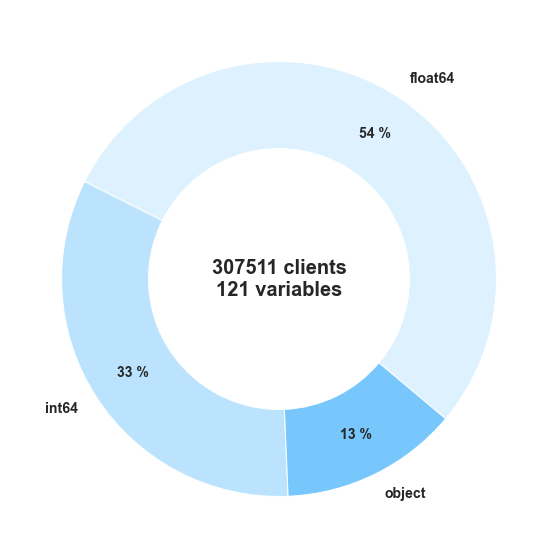

In [10]:
plt.figure(figsize=(10, 10))
dtypes = chart_data.drop(columns='TARGET').dtypes.value_counts()

plt.pie(
    x=dtypes.values, 
    labels=dtypes.index.astype(str),
    wedgeprops={'width':0.4}, 
    startangle=-40,
    autopct='%1.f %%',
    pctdistance=0.80,
    colors = palette_r,
    textprops={'fontweight': 'bold', 'fontsize': 14}
      )

plt.text(0, 0, f"{len(train_set)} clients\n{train_set.shape[1] - 1} variables", ha='center', va='center', fontsize=20, fontweight='bold')
plt.show()

In [11]:
uniques = train_set.select_dtypes(exclude='object').nunique().sort_values()

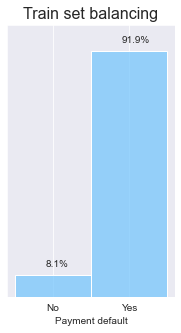

In [12]:
plt.figure(figsize=(3, 5))

target_counts = chart_data.TARGET.value_counts()

sns.histplot(x = 'TARGET', data = chart_data, color = palette[2])
plt.title('Train set balancing', size = 16)
plt.ylim(0, max(chart_data.groupby('TARGET').SK_ID_CURR.count()) + 30000)
plt.text(x = -0.1, y = target_counts['No'] + 10000, s = f'{target_counts["No"] / target_counts.sum():.1%}')
plt.text(x = 0.9, y = target_counts['Yes'] + 10000, s = f'{target_counts["Yes"] / target_counts.sum():.1%}')
plt.yticks([])
plt.ylabel('')
plt.xlabel('Payment default')

plt.show()

In [13]:
print(f'''
* number of duplicated rows: {train_set.duplicated().sum()}
''')


* number of duplicated rows: 0



In [14]:
i = train_set.isna().sum() > 0
m = train_set[train_set.columns[i]].isna().sum().mean()

print(f'''
* number of features with missing values: {i.sum()} ({i.sum() / train_set.shape[1]:.0%} of features)
* mean of missing values per feature (among features with missing values): {m:.0f} ({m / len(train_set):.2%} of clients)
''')


* number of features with missing values: 67 (55% of features)
* mean of missing values per feature (among features with missing values): 136604 (44.42% of clients)



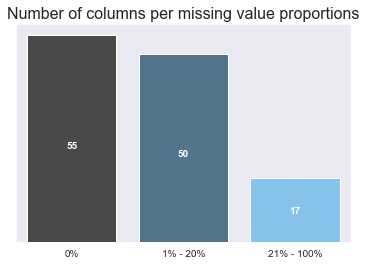

In [15]:
na_count = train_set.isna().sum() / len(train_set)
_ = pd.cut(na_count, bins=[-1, 0, 0.2, 1], include_lowest=True).value_counts()
index = [f'{cat.left+0.01:.0%} - {cat.right:.0%}' for cat in _.index.categories]
index[0] = '0%'
sns.barplot(x = index, y = _.values, palette=palette)
plt.title('Number of columns per missing value proportions', size=16)
plt.xticks(rotation=0)
for i, v in enumerate(_):
    plt.text(x=i-0.05, y=v / 2.2, s=v, c='w', weight="bold")
plt.yticks([])
plt.show()

In [16]:
description = pd.read_csv(os.path.join(STORAGE_PATH, INPUT_FOLDER, 'HomeCredit_columns_description.csv'), encoding='latin1', index_col='Unnamed: 0')
                          

In [17]:
client_type = pd.DataFrame()
for column in chart_data.select_dtypes(include='object'):
    d = description.loc[description.Row == column, 'Description'].iloc[0]
    
    client_data = pd.DataFrame({
        'description': [d],
        'all': [chart_data[column].mode()[0]],
        'solvent': [chart_data.loc[chart_data.TARGET == 'Yes', column].mode()[0]],
        'insolvent': [chart_data.loc[chart_data.TARGET == 'No', column].mode()[0]],
    }, index=[column])
    
    client_type = pd.concat([client_type, client_data])

for column in chart_data.select_dtypes(exclude='object'):
    d = description.loc[description.Row == column, 'Description'].iloc[0]
    
    client_data = pd.DataFrame({
        'description': [d],
        'all': [chart_data[column].mode()[0]],
        'solvent': [chart_data.loc[chart_data.TARGET == 'Yes', column].mean()],
        'insolvent': [chart_data.loc[chart_data.TARGET == 'No', column].mean()],
    }, index=[column])
    
    client_type = pd.concat([client_type, client_data])

In [18]:
display(client_type)

,description,all,solvent,insolvent
TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",Yes,Yes,No
NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,Cash loans,Cash loans,Cash loans
CODE_GENDER,Gender of the client,F,F,F
FLAG_OWN_CAR,Flag if the client owns a car,N,N,N
FLAG_OWN_REALTY,Flag if client owns a house or flat,Y,Y,Y
NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,Unaccompanied,Unaccompanied,Unaccompanied
NAME_INCOME_TYPE,"Clients income type (businessman, working, maternity leave, )",Working,Working,Working
NAME_EDUCATION_TYPE,Level of highest education the client achieved,Secondary / secondary special,Secondary / secondary special,Secondary / secondary special
NAME_FAMILY_STATUS,Family status of the client,Married,Married,Married
NAME_HOUSING_TYPE,"What is the housing situation of the client (renting, living with parents, ...)",House / apartment,House / apartment,House / apartment


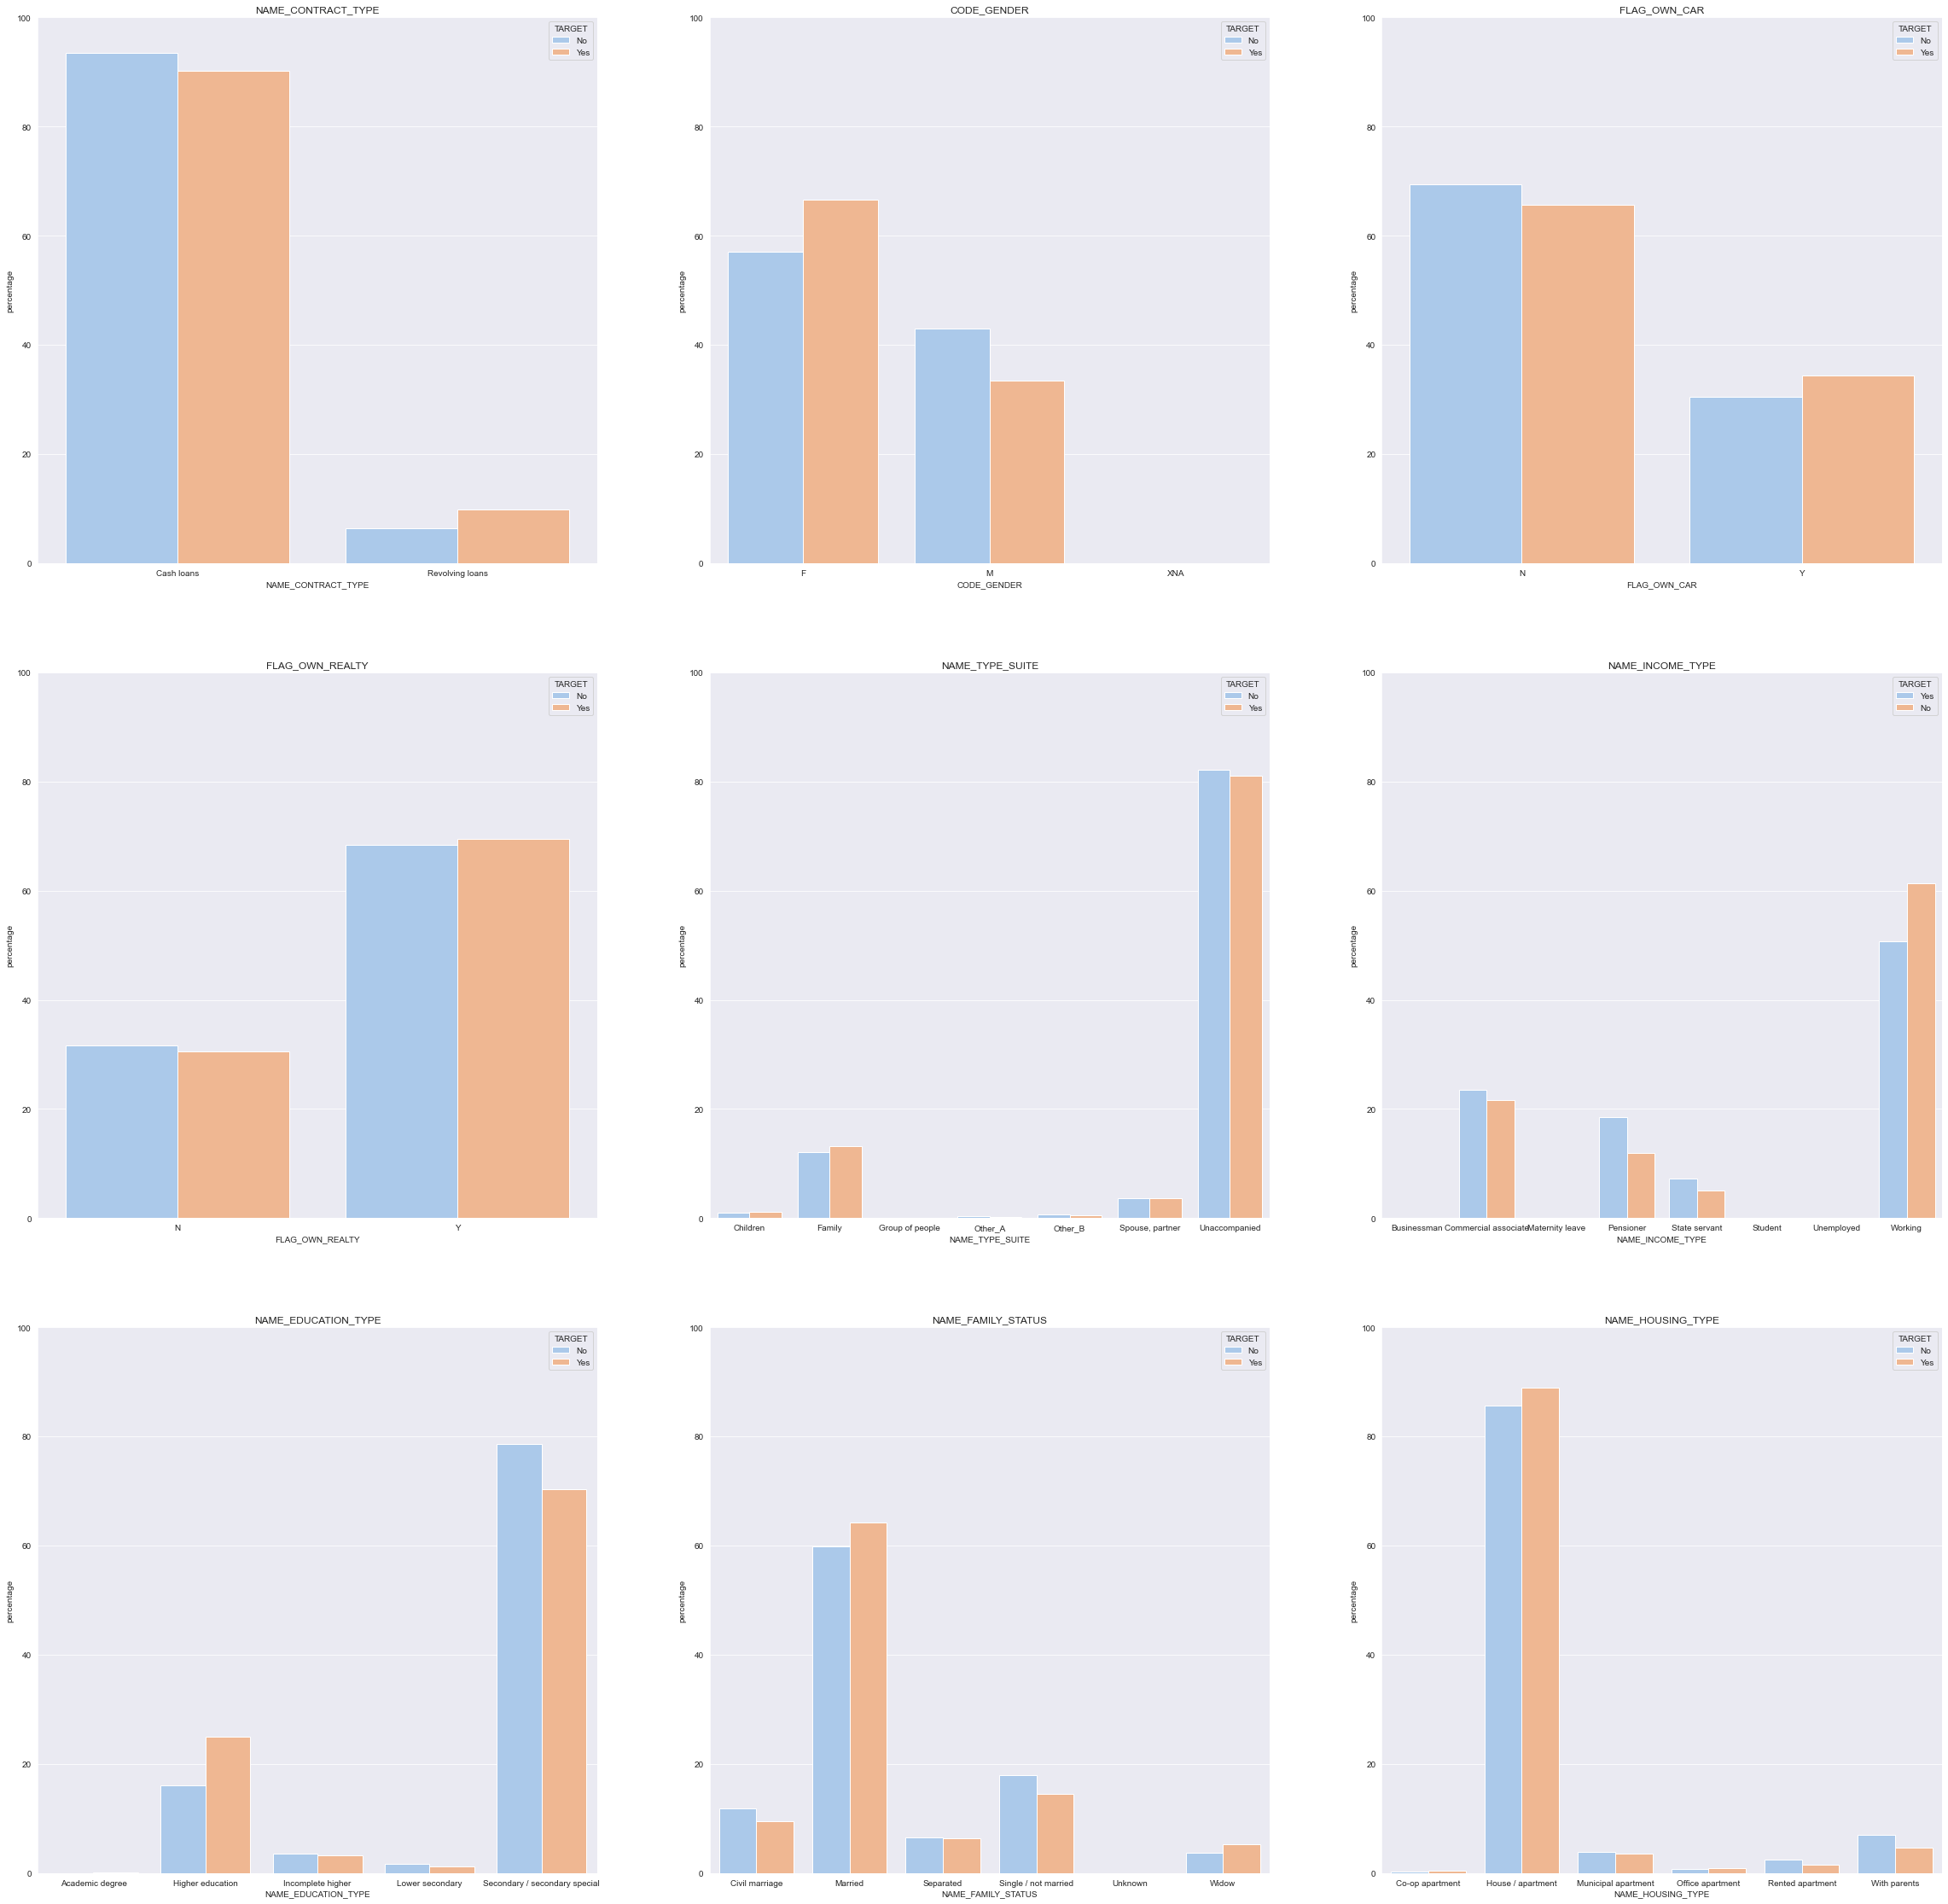

In [19]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(40, 40))

for column, ax in zip(chart_data.drop(columns='TARGET').select_dtypes(include = "object").columns, axes.flat):
    
    ax.set_title(column, size=12)
    
    counts = (chart_data.groupby(['TARGET'])[column]
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index()
                         .sort_values(column))

    g = sns.barplot(x=column, y="percentage", hue="TARGET", data=counts, palette='pastel', ax=ax)
    ax.set_ylim(0,100)   
    
plt.show()

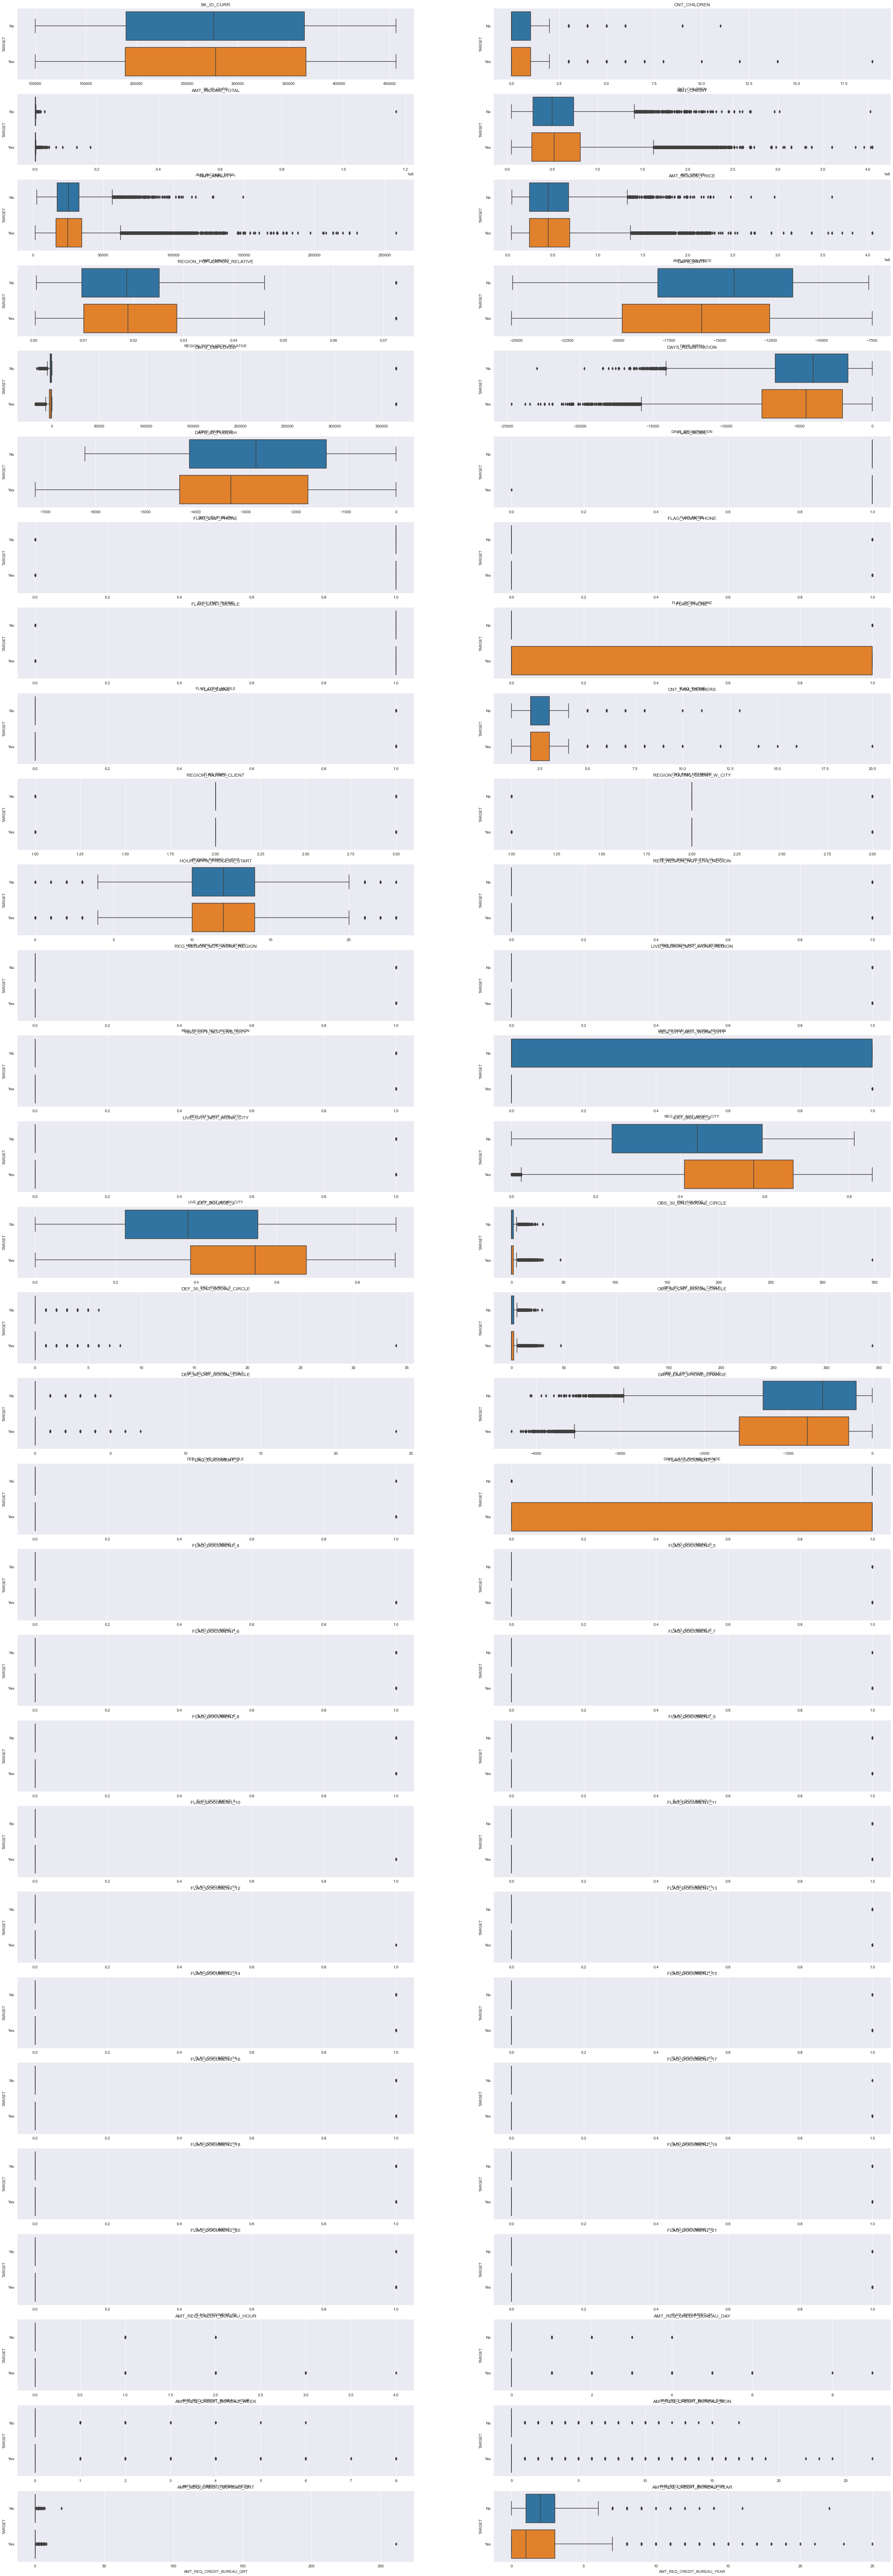

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=30, figsize=(40, 120))

# analyse only feature with less than 20% of missing values
columns = chart_data[chart_data.columns[chart_data.isna().sum() / len(chart_data) <= 0.2]].select_dtypes(exclude = "object").columns

for column, ax in zip(columns, axes.flat):
    
    ax.set_title(column, size=12)
    sns.boxplot(data = chart_data, x = column, y = 'TARGET', ax=ax)

plt.show()

# Preprocessing

In [21]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def preprocess_application(application_df:pd.DataFrame, nan_as_category:bool=False):
    
    # Read data and merge
    df = application_df.copy()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    df.set_index('SK_ID_CURR', inplace=True)
        
    return df

In [22]:
%time
train_set_preprocess = preprocess_application(train_set)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


In [23]:
print(f'''
* train set shape after preprocessing: {train_set_preprocess.shape}
''')


* train set shape after preprocessing: (307507, 246)



In [24]:
# remove feature with more than 20% of missing values
train_set_preprocess
train_set_preprocess = train_set_preprocess[train_set_preprocess.columns[train_set_preprocess.isna().sum() / len(train_set_preprocess) <= 0.2]]

print(f'''
* train set shape after remove feature with missing values: {train_set_preprocess.shape}
''')


* train set shape after remove feature with missing values: (307507, 201)



In [25]:
# impute missing values
imp = SimpleImputer(strategy='constant', fill_value=-1)

train_set_preprocess_imp = imp.fit_transform(train_set_preprocess)
train_set_preprocess_imp = pd.DataFrame(train_set_preprocess_imp, columns=train_set_preprocess.columns)

In [26]:
# scaling
sc = MinMaxScaler()
train_set_preprocess_imp_sc = sc.fit_transform(train_set_preprocess_imp)
train_set_preprocess_imp_sc = pd.DataFrame(train_set_preprocess_imp_sc, columns=train_set_preprocess.columns)

In [27]:
train_set_preprocess_imp_sc.index = train_set_preprocess.index

In [28]:
# save data
train_set_preprocess_imp_sc.reset_index().to_feather(
    os.path.join(STORAGE_PATH, OUTPUT_FOLDER, 'application_train.f'))

# Metrics

In [29]:
n = 100
y_true = np.random.randint(2, size=n)
y_pred = np.random.randint(2, size=n)

cm = confusion_matrix(y_true, y_pred)
tn, fn, fp, tp = cm[0, 0], cm[1, 0], cm[0, 1], cm[1, 1]

print("""
Number of true negative:\t%s (%s)
Number of false negative:\t%s (%s)
Number of false positive:\t%s (%s)
Number of true positive:\t%s (%s)
""" % (tn, tn/n, fn, fn/n, fp, fp/n, tp, tp/n))


Number of true negative:	26 (0.26)
Number of false negative:	26 (0.26)
Number of false positive:	26 (0.26)
Number of true positive:	22 (0.22)



## Recall

Le recall mesure la proportion des client prédit non solvable parmis tous les non solvables.

$\text{Recall}=\frac{TP}{TP + FN}$

In [30]:
recall_score(y_true, y_pred)

0.4583333333333333

## Precision

La precision mesure le nombre de client véritablement non solvable parmis tous ceux qui sont prédits non solvables.

$\text{Precision}=\frac{TP}{TP + FP}$

In [31]:
precision_score(y_true, y_pred)

0.4583333333333333

## F1-score

Le F1 score combine la precision et le recall en faisant leur moyenne harmonique.

$F1 = 2 \times \frac{precision \times recall}{precision + recall}$

In [32]:
f1_score(y_true, y_pred)

0.4583333333333333

## F-beta score

Nous cherchons ici à trouver le maximum de client non solvables, quite pour ca à se tromper sur la prédiction des solvables. Pour cela nous devons maximiser le recall.

Le F-beta score est une variante du F1 score qui introduit une variable $\beta$ qui fait varier le poids du recall par rapport à la precision. Lorsque $\beta$ tend vers 0, le poids du recall devient négligeable et de même pour la precision quand il tend vers l'infini.

$F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}$

In [33]:
fbeta_score(y_true, y_pred, beta=1) == f1_score(y_true, y_pred)

True

In [34]:
fbeta_score(y_true, y_pred, beta=0) == precision_score(y_true, y_pred)

True

In [35]:
round(fbeta_score(y_true, y_pred, beta=1000), 4) == round(recall_score(y_true, y_pred), 4)

True

## Penalisation des faux negatifs

Les faux négatifs sont les clients non solvables predits solvables. Nous cherchons ici à minimiser ces faux négatifs dans le f1-score.

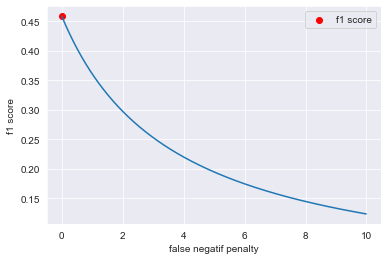

In [36]:
def f1_score_with_penalty(y_true, y_pred, penalty=float):
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fn, fp, tp = cm[0, 0], cm[1, 0], cm[0, 1], cm[1, 1]
    fn = fn * (1 + penalty)
    f1 = tp / (tp + 0.5 * (fp + fn))
    
    return f1


max_p = 10
score = [f1_score_with_penalty(y_true, y_pred, penalty=p) for p in np.arange(0, max_p, 0.01)]
plt.plot(np.arange(0, max_p, 0.01), score)
plt.scatter(0, f1_score(y_true, y_pred), c='r', label='f1 score')

plt.xlabel('false negatif penalty')
plt.ylabel('f1 score')
plt.legend()
plt.show()

Pour combiner la minimisation du recall et des faux positifs, nous ajoutons cette pénalité au F-beta score.

In [37]:
def custom_fbeta_score(y_true, y_pred, beta, penalty=float):
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fn, fp, tp = cm[0, 0], cm[1, 0], cm[0, 1], cm[1, 1]
    fn = fn * (1 + penalty)
    fbeta = ((1 + beta**2) * tp) / ((1 + beta**2) * tp + beta**2 * fn + fp)
    
    return fbeta

Nous allons maintenant évaluer sur ces différentes métriques plusieurs modèle de classification sur nos données afin de voir comment celles-ci varies et quel modèle retenir pour la suite.

In [38]:
def evaluate_model(y_true, y_pred, beta, penalty, verbose=False):
    
    a = accuracy_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    p = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fb = fbeta_score(y_true, y_pred, beta=beta)
    cfb = custom_fbeta_score(y_true, y_pred, beta=beta, penalty=penalty)
    
    if verbose:
        print(f"""

{classification_report(y_true, y_pred)}

SUMMARY
-------
* accuracy:\t{round(a, 3)}
* recall:\t{round(r, 3)}
* precision:\t{round(p, 3)}
* f1:\t\t{round(f1, 3)}
* fbeta:\t{round(fb, 3)}
* custom fbeta:\t{round(cfb, 3)}
""")
        
    return a, r, p, f1, fb, cfb

# Baseline model

In [39]:
train_set_preprocess = pd.read_feather(os.path.join(STORAGE_PATH, OUTPUT_FOLDER, 'application_train.f'))
train_set_preprocess.set_index('SK_ID_CURR', inplace=True)

In [40]:
X = train_set_preprocess.drop(columns='TARGET')

# encode feature name
feature_dict = {f"feature_{index}": column  for index, column in enumerate(X.columns)}
joblib.dump(feature_dict, os.path.join(STORAGE_PATH, OUTPUT_FOLDER, 'model_feature_dict.p'))
X.columns = feature_dict.keys()

y = train_set_preprocess.TARGET

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [43]:
%time
param_grid = dict(
    estimator = [
        DummyClassifier(random_state=0),
        LogisticRegression(random_state=0, max_iter=200),
    ]
)

pipe = Pipeline([('estimator', 'passthrough')])

scores_df = pd.DataFrame()

for i, params in enumerate(ParameterGrid(param_grid), 1):
    
    print(f"* params batch: {i} on {len(ParameterGrid(param_grid))}")
    try:
        sk = StratifiedKFold(n_splits=5)
        cv = sk.split(X_train, y_train)

        pipe.set_params(**params)
        for train, val in tqdm(cv):

            X_train_val = X_train.iloc[train]
            y_train_val = y_train.iloc[train]        
            X_val = X_train.iloc[val]
            y_val = y_train.iloc[val]

            pipe.fit(X_train_val, y_train_val)
            y_pred_val = pipe.predict(X_val)

            scores = [evaluate_model(y_val, y_pred_val, beta=3, penalty=0.1)]
            model_scores_df = pd.DataFrame(scores, columns = ['accuracy', 'recall', 'precision', 'f1', 'fbeta', 'custom_fbeta'])
            model_scores_df['model'] = type(pipe['estimator']).__name__
            model_scores_df['fold'] = i
            scores_df = pd.concat([scores_df, model_scores_df], ignore_index=True)
            
    except Exception as e:
        print(e)


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 12.2 µs
* params batch: 1 on 2


5it [00:02,  1.74it/s]


* params batch: 2 on 2


5it [01:21, 16.23s/it]


In [44]:
scores_df.groupby('model').mean()

,accuracy,recall,precision,f1,fbeta,custom_fbeta,fold
model,,,,,,,
DummyClassifier,0.852482,0.083571,0.084040,0.083805,0.083618,0.077246,1.0
LogisticRegression,0.918567,0.002363,0.176122,0.004663,0.002622,0.002384,2.0


# Sampling data

## Undersampling

In [45]:
%time
sk = StratifiedKFold(n_splits=5)
cv = sk.split(X_train, y_train)
clf = LogisticRegression(random_state=0, max_iter=200)
sampler = RandomUnderSampler(sampling_strategy=0.4, random_state=0)
scores_df = pd.DataFrame()
i = 1

for train, val in tqdm(cv):
    
    X_train_val = X_train.iloc[train]
    y_train_val = y_train.iloc[train]  
    X_train_val_samp, y_train_val_samp = sampler.fit_resample(X_train, y_train)
    X_val = X_train.iloc[val]
    y_val = y_train.iloc[val]

    clf.fit(X_train_val_samp, y_train_val_samp)
    y_pred_val = clf.predict(X_val)

    scores = [evaluate_model(y_val, y_pred_val, beta=3, penalty=0.1)]
    model_scores_df = pd.DataFrame(scores, columns = ['accuracy', 'recall', 'precision', 'f1', 'fbeta', 'custom_fbeta'])
    model_scores_df['fold'] = i
    
    i += 1
    scores_df = pd.concat([scores_df, model_scores_df], ignore_index=True)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 20 µs


5it [00:30,  6.16s/it]


In [46]:
scores_df.mean().to_frame().T

,accuracy,recall,precision,f1,fbeta,custom_fbeta,fold
0,0.880276,0.228692,0.243164,0.235699,0.230058,0.215043,3.0


## SMOTE

In [47]:
%time
sk = StratifiedKFold(n_splits=5)
cv = sk.split(X_train, y_train)
clf = LogisticRegression(random_state=0, max_iter=200)
sampler = SMOTE(sampling_strategy=0.3, random_state=0)
scores_df = pd.DataFrame()
i = 1

for train, val in tqdm(cv):
    
    X_train_val = X_train.iloc[train]
    y_train_val = y_train.iloc[train]  
    X_train_val_samp, y_train_val_samp = sampler.fit_resample(X_train, y_train)
    X_val = X_train.iloc[val]
    y_val = y_train.iloc[val]

    clf.fit(X_train_val_samp, y_train_val_samp)
    y_pred_val = clf.predict(X_val)

    scores = [evaluate_model(y_val, y_pred_val, beta=3, penalty=0.1)]
    model_scores_df = pd.DataFrame(scores, columns = ['accuracy', 'recall', 'precision', 'f1', 'fbeta', 'custom_fbeta'])
    model_scores_df['fold'] = i
    
    i += 1
    scores_df = pd.concat([scores_df, model_scores_df], ignore_index=True)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs


5it [13:43, 164.71s/it]


In [48]:
scores_df.mean().to_frame().T

,accuracy,recall,precision,f1,fbeta,custom_fbeta,fold
0,0.897472,0.156615,0.268414,0.197769,0.163413,0.151426,3.0


## Class weight

In [49]:
%time
sk = StratifiedKFold(n_splits=5)
cv = sk.split(X_train, y_train)
clf = LogisticRegression(random_state=0, max_iter=200, class_weight='balanced')
scores_df = pd.DataFrame()
i = 1

for train, val in tqdm(cv):
    
    X_train_val = X_train.iloc[train]
    y_train_val = y_train.iloc[train]  
    X_val = X_train.iloc[val]
    y_val = y_train.iloc[val]

    clf.fit(X_train_val, y_train_val)
    y_pred_val = clf.predict(X_val)

    scores = [evaluate_model(y_val, y_pred_val, beta=3, penalty=0.1)]
    model_scores_df = pd.DataFrame(scores, columns = ['accuracy', 'recall', 'precision', 'f1', 'fbeta', 'custom_fbeta'])
    model_scores_df['fold'] = i
    
    i += 1
    scores_df = pd.concat([scores_df, model_scores_df], ignore_index=True)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 26.7 µs


5it [00:59, 11.91s/it]


In [50]:
scores_df.mean().to_frame().T

,accuracy,recall,precision,f1,fbeta,custom_fbeta,fold
0,0.666032,0.6459,0.145849,0.237962,0.480984,0.469835,3.0


# Model selection

In [51]:
%time
param_grid = dict(
    estimator = [
        LogisticRegression(random_state=0, class_weight='balanced'),
        lgb.LGBMClassifier(random_state=0, class_weight='balanced'),
        RandomForestClassifier(random_state=0, class_weight='balanced'),    
    ]
)

pipe = Pipeline([('estimator', 'passthrough')])

scores_df = pd.DataFrame()

for i, params in enumerate(ParameterGrid(param_grid), 1):
    
    print(f"* params batch: {i} on {len(ParameterGrid(param_grid))}")
    try:
        
        sk = StratifiedKFold(n_splits=5)
        cv = sk.split(X_train, y_train)
        j = 0
        pipe.set_params(**params)

        for train, val in tqdm(cv):

            X_train_val = X_train.iloc[train]
            y_train_val = y_train.iloc[train]        
            X_val = X_train.iloc[val]
            y_val = y_train.iloc[val]

            pipe.fit(X_train_val, y_train_val)
            y_pred_val = pipe.predict(X_val)
            
            scores = [evaluate_model(y_val, y_pred_val, beta=3, penalty=0.1)]
            model_scores_df = pd.DataFrame(scores, columns = ['accuracy', 'recall', 'precision', 'f1', 'fbeta', 'custom_fbeta'])
            model_scores_df['model'] = type(pipe['estimator']).__name__
            model_scores_df['fold'] = j
            j += 1
            
            scores_df = pd.concat([scores_df, model_scores_df], ignore_index=True)

    except Exception as e:
        print(e)


CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 13.8 µs
* params batch: 1 on 3


5it [00:42,  8.41s/it]


* params batch: 2 on 3


5it [00:26,  5.26s/it]


* params batch: 3 on 3


5it [07:08, 85.73s/it]


In [52]:
scores_df.groupby('model').mean()

,accuracy,recall,precision,f1,fbeta,custom_fbeta,fold
model,,,,,,,
LGBMClassifier,0.709487,0.667329,0.169670,0.270550,0.515983,0.504310,2.0
LogisticRegression,0.665460,0.643805,0.145277,0.237060,0.479319,0.468148,2.0
RandomForestClassifier,0.919286,0.001020,0.588571,0.002036,0.001134,0.001031,2.0


# Fine tunning

In [54]:
def lgb_custom_metrics(y_true, y_pred):
    
    beta = 3
    penalty = 0.01
    y_pred = np.round(y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fn, fp, tp = cm[0, 0], cm[1, 0], cm[0, 1], cm[1, 1]
    fn = fn * (1 + penalty)
    fbeta = ((1 + beta**2) * tp) / ((1 + beta**2) * tp + beta**2 * fn + fp)
    
    return 'custom_fbeta', fbeta, True

def objective(params, n_folds=5):
    """Objective function for Gradient Boosting Machine Hyperparameter Tuning"""

    sk = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
    cv = sk.split(X_train, y_train)
    
    params['subsample'] = params['boosting_type'].get('subsample', 1.0)
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['n_estimators'] = 100
    params['class_weight'] = 'balanced'
    params['metric'] = 'custom'
    params['random_state'] = 0
    
    clf = lgb.LGBMClassifier(**params)

    cv_scores = list()
    for train, val in cv:

        X_train_val = X.iloc[train]
        y_train_val = y.iloc[train]  
        X_val = X.iloc[val]
        y_val = y.iloc[val]

        clf.fit(X_train_val, y_train_val, 
                eval_set=[(X_val, y_val)], 
                early_stopping_rounds=10, 
                eval_metric=lgb_custom_metrics,
                verbose=-1)
        
        best_score = clf.best_score_['valid_0']['custom_fbeta']
        
        cv_scores.append(best_score)
    
    loss = 1 - np.mean(cv_scores)
    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

space = {
    'boosting_type': hp.choice('boosting_type', 
                               [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                {'boosting_type': 'goss'}]),
    'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}

tpe_algorithm = tpe.suggest
bayes_trials = Trials()

MAX_EVALS = 5

# Optimize
best = fmin(
    fn = objective, 
    space = space, 
    algo = tpe.suggest, 
    max_evals = MAX_EVALS, 
    trials = bayes_trials)

100%|███████████| 5/5 [07:13<00:00, 86.62s/trial, best loss: 0.4892621462934875]


# Feature importances

In [55]:
print(f'''
* best score: {round(1 - bayes_trials.best_trial['result']['loss'], 2)}
''')


* best score: 0.51



In [56]:
params = bayes_trials.best_trial['result']['params']
display(pd.Series(params).to_frame().T)

,boosting_type,learning_rate,num_leaves,reg_alpha,reg_lambda,subsample,n_estimators,class_weight,metric,random_state
0,goss,0.095307,96,0.254943,0.174952,1.0,100,balanced,custom,0


In [61]:
clf = lgb.LGBMClassifier(**params)

clf.fit(X_train, y_train, 
        eval_set=[(X_test, y_test)], 
        early_stopping_rounds=10, 
        eval_metric=lgb_custom_metrics, 
        verbose=-1)

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.0953074538957127, metric='custom', num_leaves=96,
               random_state=0, reg_alpha=0.25494312344158454,
               reg_lambda=0.1749516287930416)

In [64]:
# save model
joblib.dump(clf, os.path.join(STORAGE_PATH, OUTPUT_FOLDER, 'model.p'))

['../data/outputs/model.p']

In [62]:
y_pred = clf.predict(X_test)

In [63]:
custom_fbeta_score(y_test, y_pred, beta=3, penalty=0.1)

0.505075905077342

In [65]:
feature_names = [feature_dict[feature] for feature in clf.feature_name_]
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, feature_names)), columns=['Value','Feature'])

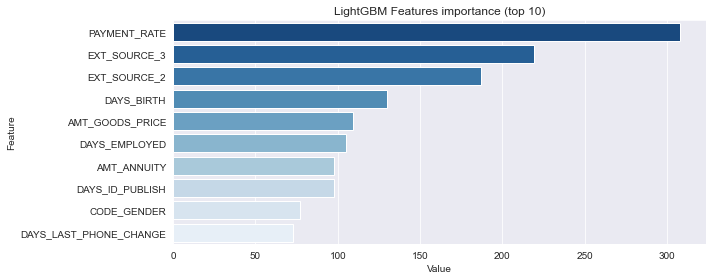

In [66]:
plt.figure(figsize=(10, 4))
sns.barplot(x="Value", y="Feature", data=feature_imp.tail(10).sort_values(by="Value", ascending=False), palette='Blues_r')
plt.title('LightGBM Features importance (top 10)')
plt.tight_layout()
plt.show()